# Assessment: Analyzing Soccer Data

TODO: add intro

## 0. Set-up

### a. Load linting tool, create spark session, etc.

In [1]:
%load_ext pycodestyle_magic

In [2]:
#%%pycodestyle
from pyspark.sql import SparkSession
import pyspark.sql.functions as func

# Create spark app
spark = (
    SparkSession
    .builder
    .appName("rb assessment app")
    .getOrCreate()
)


### a. Data Engineering for Task 1

In [3]:
#%%pycodestyle
import pyspark.sql.functions as func

bl_results_spark_df = (
    # read matches folder
    spark
    .read
    .json(
        "data/matches/*/",
        multiLine=True
    )
    # filter 1. Bundesliga 2015/16 matches
    .where(
        func.col("competition.competition_name").eqNullSafe("1. Bundesliga")
        & func.col("season.season_name").eqNullSafe("2015/2016")
    )
    # order by date to make sure that the ELO function is used approprietly
    .orderBy(func.to_date("match_date"))
    # perform the mapping to get one row for each team and match
    # the associated result is:
    # - win = 1
    # - draw = 0.5
    # - loss = 0
    .select(
        func.col(
            "home_team.home_team_name"
        ).alias("home_team_name"),
        func.col(
            "away_team.away_team_name"
        ).alias("away_team_name"),
        func.coalesce(
            func.when(func.expr("home_score > away_score"), 1),
            func.when(func.expr("home_score < away_score"), 0),
            func.lit(0.5)
        ).alias("home_team_result"),
        func.coalesce(
            func.when(func.expr("home_score > away_score"), 0),
            func.when(func.expr("home_score < away_score"), 1),
            func.lit(0.5)
        ).alias("away_team_result")
    )
)

# print schema for verification
bl_results_spark_df.printSchema()

# cache result to pandas df
bl_result_df = bl_results_spark_df.toPandas()
# display resulting df
print(bl_result_df)

root
 |-- home_team_name: string (nullable = true)
 |-- away_team_name: string (nullable = true)
 |-- home_team_result: double (nullable = false)
 |-- away_team_result: double (nullable = false)

    home_team_name            away_team_name  home_team_result  \
0    Bayern Munich              Hamburger SV               1.0   
1         Augsburg             Hertha Berlin               0.0   
2    Werder Bremen                Schalke 04               0.0   
3     FSV Mainz 05                Ingolstadt               0.0   
4     Darmstadt 98               Hannover 96               0.5   
..             ...                       ...               ...   
301   Darmstadt 98  Borussia Mönchengladbach               0.0   
302  Bayern Munich               Hannover 96               1.0   
303   FSV Mainz 05             Hertha Berlin               0.5   
304  Werder Bremen       Eintracht Frankfurt               1.0   
305      Wolfsburg             VfB Stuttgart               1.0   

     away_t

## 1. Task 1 - Elo Rating

### a. Develop a function to implement the ELO Rating System with arbitrary K and s.

In [4]:
#%%pycodestyle
import math
import operator


def predict(rating_a, rating_b, s=15):
    """Calculate the expected outcome for team A given ratings."""
    return 1 / (1 + math.pow(10, -(rating_a - rating_b) / s))


def update_elo(rating_a, rating_b, outcome, s=15, K=15):
    """Update the ELO rating of a team after a match."""
    pred = predict(rating_a, rating_b, s)
    return rating_a + K * (outcome - pred)


def process_match(ratings, home_team, away_team, home_result, away_result,
                  s, K):
    """Update ratings after processing a match."""
    # Update home team rating
    ratings[home_team] = update_elo(
        ratings[home_team], ratings[away_team], home_result, s, K
    )
    # Update away team rating
    ratings[away_team] = update_elo(
        ratings[away_team], ratings[home_team], away_result, s, K
    )
    return ratings


def initialize_ratings(teams, initial_rating=100):
    """Initialize the ratings for all teams."""
    return {team_name: initial_rating for team_name in teams}


def elo(results, s=15, K=15, R_0=100):
    """Calculate the final ELO ratings for all teams."""
    # Initialize ratings
    ratings = initialize_ratings(results["home_team_name"].unique(), R_0)
    for row in results.itertuples(index=False):
        # Update ratings based on the match result
        process_match(
            ratings,
            row.home_team_name,
            row.away_team_name,
            row.home_team_result,
            row.away_team_result,
            s, K
        )
    # Sort the ratings in descending order
    return dict(
        sorted(ratings.items(), key=operator.itemgetter(1), reverse=True)
    )


### b. Apply the rating system to 1. Bundesliga 2015/2016 Season with starting values R0 = 100, s = 15 and K = 15.

In [5]:
elo(bl_result_df)

{'Borussia Mönchengladbach': 128.73684750507124,
 'Bayern Munich': 126.03882090784246,
 'Werder Bremen': 122.53431008967196,
 'Bayer Leverkusen': 119.86744451903735,
 'Schalke 04': 116.7404982618847,
 'Eintracht Frankfurt': 115.13792895836448,
 'Borussia Dortmund': 113.14276236567889,
 'FC Köln': 112.7931080154221,
 'Hannover 96': 112.683637686516,
 'Darmstadt 98': 104.6708369599969,
 'Hoffenheim': 104.14444368636025,
 'Ingolstadt': 104.05781546247819,
 'Hamburger SV': 103.82508894341434,
 'Wolfsburg': 103.54107736006338,
 'Augsburg': 100.16514926109396,
 'FSV Mainz 05': 98.21672472241177,
 'Hertha Berlin': 96.401623690483,
 'VfB Stuttgart': 88.0062841309003}

### c. Develop an approach that finds the optimal values for s and K based on that season and display the final ranking table at the end of the season.

We could take the assumption that the optimal values for parameters s and K are the one that would minimize the discrepancy between the predicted outcome and actual match result for each step of that particular season.

Let's define our loss function as the average brier score of our ELO Rating System.

In [6]:
#%%pycodestyle

def brier_score(results, s=15, K=15, R_0=100):
    """
    Calculate the Brier score based on the predicted outcomes and actual
    results.
    """
    ratings = initialize_ratings(results["home_team_name"].unique(), R_0)
    total_brier_score = 0
    for row in results.itertuples(index=False):
        # Get teams predictions
        home_rating = ratings[row.home_team_name]
        away_rating = ratings[row.away_team_name]

        home_pred = predict(home_rating, away_rating, s)
        away_pred = 1 - home_pred

        # Calculate Brier score for both teams
        total_brier_score += (home_pred - row.home_team_result) ** 2
        total_brier_score += (away_pred - row.away_team_result) ** 2

        # Update ratings after the match
        process_match(
            ratings,
            row.home_team_name,
            row.away_team_name,
            row.home_team_result,
            row.away_team_result,
            s, K
        )

    # Return the average Brier score
    return total_brier_score / (2 * len(results))

brier_score(bl_result_df)


0.23717873793811076

We are going to try finding good values for s and K params for brier_score in terms of brier score using bayesian optimization.
It is a sampling method based on exploration and optimization.

In [17]:
#%%pycodestyle
from functools import partial
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'s': (15, 300), 'K': (15, 30)}

def neg_brier_score(s, K):
    return - brier_score(bl_result_df, s=s, K=K)

optimizer = BayesianOptimization(
    f=neg_brier_score,
    pbounds=pbounds,
    random_state=1,
    verbose=1
)

optimizer.maximize(
    init_points=32,
    n_iter=128,
)

|   iter    |  target   |     K     |     s     |
-------------------------------------------------
| 7         | -0.178    | 18.07     | 265.3     |
| 8         | -0.1779   | 15.41     | 206.1     |
| 44        | -0.1779   | 22.83     | 300.0     |
| 59        | -0.1779   | 15.0      | 200.4     |
| 94        | -0.1779   | 18.18     | 241.4     |
| 130       | -0.1779   | 20.45     | 271.1     |


In [18]:
res = optimizer.max
print(res)

{'target': np.float64(-0.17791904423717828), 'params': {'K': np.float64(20.44873714712105), 's': np.float64(271.1405558615955)}}


In [19]:
elo(bl_result_df, s=res["params"]["s"], K=res["params"]["K"])

{'Bayern Munich': np.float64(239.10714701168303),
 'Borussia Dortmund': np.float64(202.74555857602832),
 'Bayer Leverkusen': np.float64(156.15384473399382),
 'Borussia Mönchengladbach': np.float64(135.36332335175678),
 'Schalke 04': np.float64(117.98494348740996),
 'FSV Mainz 05': np.float64(106.89958701018837),
 'FC Köln': np.float64(95.41208312462189),
 'Hertha Berlin': np.float64(95.35379411470757),
 'Wolfsburg': np.float64(83.21128855250517),
 'Augsburg': np.float64(81.1916679150901),
 'Hoffenheim': np.float64(80.0920946039107),
 'Werder Bremen': np.float64(77.97082248179228),
 'Hamburger SV': np.float64(74.23642223799513),
 'Darmstadt 98': np.float64(71.19245828494051),
 'Ingolstadt': np.float64(71.0165776348987),
 'Eintracht Frankfurt': np.float64(70.6169902683531),
 'VfB Stuttgart': np.float64(37.66955722879909),
 'Hannover 96': np.float64(19.194387968792206)}

As we can see, the final ranking at the end of the season is strongly correlated with the actual league table.
But, we could try optimizing the parameters a bit further using gradient descent from those starting parameters.
Gradient descent is a standard practice in machine learning to find parameters that allow a function to reach a minimum in terms of loss.

In [35]:
#%%pycodestyle
import torch
from torch.optim import Adam


# Define the PyTorch version of predict
def predict_torch(rating_a, rating_b, s):
    return 1 / (1 + torch.pow(10, -(rating_a - rating_b) / s))


# Define the PyTorch version of update_elo
def update_elo_torch(rating_a, rating_b, outcome, s, K):
    pred = predict_torch(rating_a, rating_b, s)
    return rating_a + K * (outcome - pred)


# Convert the brier_score function to work with PyTorch tensors
def brier_score_torch(results_df, s, K):
    # Initialize ratings with PyTorch tensors
    unique_teams = results_df["home_team_name"].unique()
    ratings = {
        team_name: torch.tensor(100.0, requires_grad=False)
        for team_name in unique_teams
    }

    total_brier_score = torch.tensor(0.0, dtype=torch.float32)

    for row in results_df.itertuples(index=False):
        home_rating = ratings[row.home_team_name]
        away_rating = ratings[row.away_team_name]

        # Use the torch-based predict function
        home_pred = predict_torch(home_rating, away_rating, s)
        away_pred = 1 - home_pred

        home_team_result = torch.tensor(
            [row.home_team_result], dtype=torch.float32
        )
        away_team_result = torch.tensor(
            [row.away_team_result], dtype=torch.float32
        )

        # Accumulate Brier score and ensure correct shape
        total_brier_score = total_brier_score \
            + torch.pow(home_pred - home_team_result, 2)
        total_brier_score = total_brier_score \
            + torch.pow(away_pred - away_team_result, 2)

        # Update ratings with torch-based update function
        ratings[row.home_team_name] = update_elo_torch(
            home_rating, away_rating, row.home_team_result, s, K
        )
        ratings[row.away_team_name] = update_elo_torch(
            away_rating, home_rating, row.away_team_result, s, K
        )

    # Return the average Brier score as a tensor
    return total_brier_score / (2 * len(results_df))


# Initial values for s and K as torch tensors (requires gradients)
s = torch.tensor([res["params"]["s"]], requires_grad=True)
K = torch.tensor([res["params"]["K"]], requires_grad=True)

# Define the optimizer
optimizer = Adam([s, K], lr=0.001)

# Number of gradient descent steps
n_iterations = 500

# Perform gradient descent
for i in range(n_iterations):
    optimizer.zero_grad()  # Zero the gradients from the previous iteration

    # Calculate the Brier score
    loss = brier_score_torch(bl_result_df, s, K)

    # Backpropagation to compute gradients
    loss.backward()

    # Perform a step of gradient descent
    optimizer.step()

    # Optionally, print progress
    if i % 100 == 0:
        print(f"Iteration {i}: Brier score = {loss.item()}, s = {s.item()}, K = {K.item()}")

# Final optimized values of s and K
print(f"Optimized s: {s.item()}, Optimized K: {K.item()}")


Iteration 0: Brier score = 0.17795345066574975, s = 271.14154310709904, K = 20.447738120511808
Iteration 100: Brier score = 0.17795254370403202, s = 271.2349039633821, K = 20.35309214544007
Iteration 200: Brier score = 0.17795199812485302, s = 271.3126315462579, K = 20.273932400837435
Iteration 300: Brier score = 0.17795170632470167, s = 271.3735168370143, K = 20.21162764201154
Iteration 400: Brier score = 0.17795156975407675, s = 271.4180023744578, K = 20.16588990044537
Optimized s: 271.4477628525792, Optimized K: 20.135156178137716


In [23]:
elo(bl_result_df, s=s.item(), K=K.item())

{'Bayern Munich': 238.11614695578442,
 'Borussia Dortmund': 202.10731690794827,
 'Bayer Leverkusen': 155.58162112932683,
 'Borussia Mönchengladbach': 134.8976205950394,
 'Schalke 04': 117.80211535227875,
 'FSV Mainz 05': 106.9566223178877,
 'Hertha Berlin': 95.6603558234831,
 'FC Köln': 95.37158298186573,
 'Wolfsburg': 83.44786249701849,
 'Augsburg': 81.22629511106862,
 'Hoffenheim': 80.08479250444809,
 'Werder Bremen': 77.92219184991505,
 'Hamburger SV': 74.46172196837092,
 'Darmstadt 98': 71.39588595656109,
 'Ingolstadt': 71.31005191484432,
 'Eintracht Frankfurt': 70.64756396595439,
 'VfB Stuttgart': 38.3064811665141,
 'Hannover 96': 19.632316449702756}

Gradient descent does not change the final rankings, but it found a slightly lower K value and higher s value indincating slower ELO updates and more conservative outcome predictions.

## 2. Task 2 - Research Problem Corners

### a. Use the whole data set of Free Statsbomb Data to help you find general offensive trends.

In [3]:
events = (
    spark
    .read
    .json(
        "data/events/",
        multiLine=True
    )
    .withColumn("match_id", func.regexp_extract(func.input_file_name(), "/(\\d+)\\.json$", 1))
)

In [4]:
matches = (
    spark
    .read
    .json(
        "data/matches/*/",
        multiLine=True
    )
)

In [6]:
from pyspark.sql import Window

window_spec_xg = Window.partitionBy("match_id", "possession").orderBy("minute", "second")
window_spec_events = Window.partitionBy("match_id", "period").orderBy("minute", "second")

start_y = func.col("location").getItem(1)
end_x = func.col("pass.end_location").getItem(0)
end_y = func.col("pass.end_location").getItem(1)
right_side_corner = (start_y > 40)
inswinging = (
    (right_side_corner & func.col("pass.body_part.name").eqNullSafe("Left Foot"))
    | (~right_side_corner & func.col("pass.body_part.name").eqNullSafe("Right Foot"))
)

corners = (
    events
    .withColumn(
        "xg",
        func.coalesce(
            func.first("shot.statsbomb_xg", ignorenulls=True).over(window_spec_xg.rowsBetween(Window.currentRow, 5)),
            func.lit(0)
        )
    )
    .withColumn(
        "next_event_id",
        func.lag("id", -1).over(window_spec_events)
    )
    .withColumn(
        "next_event_team",
        func.lag("team.name", -1).over(window_spec_events)
    )
    .where("pass.type.name='Corner'")
    .join(matches, on="match_id", how="left")
    .select(
        "match_id",
        func.col("season.season_name").alias("season"),
        func.col("id").alias("event_id"),
        func.col("team.name").alias("team"), 
        "next_event_id",
        "next_event_team",
        right_side_corner.alias("y_symetry_applied"),
        end_x.alias("end_x"), 
        # horizontal symmetry
        func.when(right_side_corner, 80 - end_y).otherwise(end_y).alias("end_y"),
        # horizontal symmetry
        func.when(inswinging, "Inswinging").otherwise("Outswinging").alias("technique"),
        "xg"
    )
)

corners.write.parquet("data/processed/corners", mode="overwrite")

In [84]:
corners = (
    spark
    .read
    .parquet("data/processed/corners")
)

In [4]:
# Step 1: Prepare the data (use 'end_x' and 'end_y')
X = corners.where("technique='Outswinging'").toPandas()[['end_x', 'end_y']].values  # Convert to NumPy array for sklearn

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["full", "tied", "spherical"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(X)

C:\Users\leo\Documents\Repositories\rb-ds-assessment\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['full', 'tied', 'spherical'],
                         'n_components': range(1, 7)},
             scoring=<function gmm_bic_score at 0x00000203474044A0>)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from scipy import linalg

color_iter = sns.color_palette("tab10", 10)[::-1]
Y_ = grid_search.predict(X)

fig, ax = plt.subplots()

for i, (mean, cov, color) in enumerate(
    zip(
        grid_search.best_estimator_.means_,
        grid_search.best_estimator_.covariances_,
        color_iter,
    )
):
    if grid_search.best_estimator_.covariance_type == "diag":
        v = cov
        w = np.eye(len(cov))
    else:
        v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ellipse = Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color, label=f"Component {i}")
    ellipse.set_clip_box(fig.bbox)
    ellipse.set_alpha(0.5)
    ax.add_artist(ellipse)

plt.title(
    f"Selected GMM: {grid_search.best_params_['covariance_type']} model, "
    f"{grid_search.best_params_['n_components']} components"
)
plt.xlim(60, 120)
plt.ylim(0, 80)
plt.legend()
plt.show()

In [151]:
df = corners.where("technique='Inswinging'").toPandas()
components = [f"Component {i}" for i in range(len(grid_search.best_estimator_.means_))]
df[components] = grid_search.predict_proba(df[['end_x', 'end_y']].values)
df[components].multiply(df["xg"], axis="rows").sum() / df[components].sum()

Component 0    0.026208
Component 1    0.001939
Component 2    0.018886
Component 3    0.006123
Component 4    0.026458
Component 5    0.003990
dtype: float64

In [152]:
df[components].sum() / df[components].sum().sum() * 100

Component 0    34.327230
Component 1    10.735656
Component 2    29.139784
Component 3     4.681218
Component 4    12.071740
Component 5     9.044373
dtype: float64

In [83]:
import pyspark.sql.types as types
schema = types.StructType([
    types.StructField('event_uuid', types.StringType()),
    types.StructField(
        'freeze_frame',
        types.ArrayType(
            types.StructType([
                types.StructField('actor', types.BooleanType()),
                types.StructField('keeper', types.BooleanType()),
                types.StructField('location', types.ArrayType(types.DoubleType())),
                types.StructField('teammate', types.BooleanType())
            ])
        )
    ), 
    types.StructField('visible_area', types.ArrayType(types.DoubleType()))
])

three_sixty = (
    spark
    .read
    .schema(schema)
    .json("data/three-sixty/", multiLine=True)
)

In [85]:
from pyspark.sql import Window

players = (
    corners.alias("corner")
    .join(
        three_sixty.alias("event"),
        on=func.expr("corner.event_id=event.event_uuid"),
        how="left"
    )
    .select(
        "event.event_uuid",
        func.posexplode("event.freeze_frame").alias("player_id", "player"),
        "y_symetry_applied",
        "xg"
    )
    .withColumn(
        "player",
        func.col("player")
        .withField(
            "location", 
            func.when(
                func.col("y_symetry_applied"), 
                func.array(
                    func.col("player.location").getItem(0),
                    80 - func.col("player.location").getItem(1)
                )
            ).otherwise(func.col("player.location"))
        )
    )
    .where(
        # player inside penalty box
        func.col("player.location").getItem(0).between(102, 120)
        & func.col("player.location").getItem(1).between(18, 62)
    )
)

team = (
    players
    .where("player.teammate AND not player.keeper AND not player.actor")
     .withColumn(
        "attacker_id", 
        func.row_number().over(Window.partitionBy("event_uuid").orderBy("player_id")) - func.lit(1)
    )
    .withColumn(
        "n_players_in_box", 
        func.sum(
            func.when(
                func.col("player.location").getItem(0).between(114, 120)
                & func.col("player.location").getItem(1).between(30, 50),
                1
            ).otherwise(0)
        ).over(Window.partitionBy("event_uuid"))
    )
    .alias("team")
)
opponent = (
    players
    .where("not player.teammate AND not player.keeper")
    .withColumn(
        "defender_id", 
        func.row_number().over(Window.partitionBy("event_uuid").orderBy("player_id")) - func.lit(1)
    )
    .withColumn(
        "n_players_in_box", 
        func.sum(
            func.when(
                func.col("player.location").getItem(0).between(114, 120)
                & func.col("player.location").getItem(1).between(30, 50),
                1
            ).otherwise(0)
        ).over(Window.partitionBy("event_uuid"))
    )
    .alias("opponent")
)
pairing = (
    team.join(opponent, "event_uuid", "left")
    .select(
        "event_uuid",
        func.col("opponent.defender_id"),
        func.col("opponent.player.location"),
        func.col("team.attacker_id"),
        func.col("team.n_players_in_box").alias("n_team_players_in_box"),
        func.col("opponent.n_players_in_box").alias("n_opponent_players_in_box"),
        func.sqrt(
            (func.col("team.player.location").getItem(0) - func.col("opponent.player.location").getItem(0)) ** 2
            + (func.col("team.player.location").getItem(1) - func.col("opponent.player.location").getItem(1)) ** 2
        ).alias("distance"),
        func.col("team.xg")
    )
)

pairing.write.parquet("data/processed/pairing", mode="overwrite")

In [86]:
pairing = (
    spark
    .read
    .parquet("data/processed/pairing")
)

In [87]:
import pandas as pd
from scipy.optimize import linear_sum_assignment

def assignment(pdf: pd.DataFrame):
    cost_matrix = pdf.pivot(index="defender_id", columns="attacker_id", values="distance")
    row_id, col_id = linear_sum_assignment(cost_matrix)
    #costs = cost_matrix.to_numpy()[row_id, col_id]
    return list(zip(row_id, col_id))


s = pairing.toPandas().groupby("event_uuid").apply(assignment, include_groups=False).explode()
res = s.reset_index()
res[["defender_id", "attacker_id"]] = pd.DataFrame(res[0].tolist(), index=res.index)
mapping = spark.createDataFrame(res.drop(columns=[0]))

In [89]:
df = (
    pairing
    .join(mapping.withColumn("marking", func.lit(1)), ["event_uuid", "defender_id", "attacker_id"], "left")
    .groupBy("event_uuid", "defender_id")
    .agg(
        func.coalesce(
            func.first(func.when(func.col("marking").isNotNull(), func.col("distance")), ignorenulls=True),
            func.max("distance")
        ).alias("marking_distance"),
        func.first("location").alias("location"),
        func.first("xg").alias("xg")
    )
    .withColumn(
        "x",
        func.col("location").getItem(0)
    )
    .withColumn(
        "y",
        func.col("location").getItem(1)
    )
    .withColumn(
        "goal_distance",
        func.sqrt(
            (func.col("location").getItem(0) - 120) ** 2
            + (func.col("location").getItem(1) - 40) ** 2
        )
    )
)

df.write.parquet("data/processed/corners_v2", mode="overwrite")

In [90]:
df = (
    spark
    .read
    .parquet("data/processed/corners_v2")
)

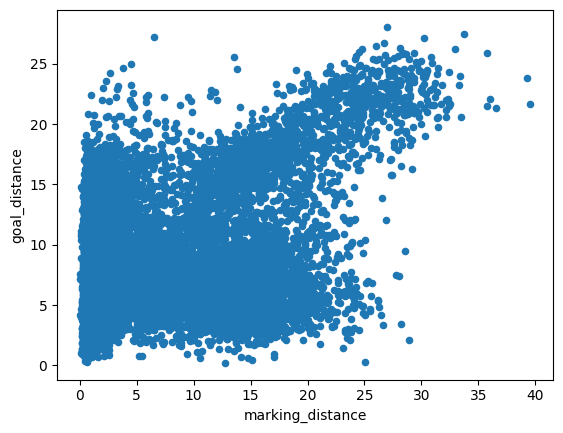

In [91]:
import matplotlib.pyplot as plt

#df.toPandas().marking_distance.plot.hist(bins=50)
df.toPandas().plot.scatter("marking_distance", "goal_distance")
plt.show()

In [204]:
# Step 1: Prepare the data (use 'end_x' and 'end_y')
X = df.toPandas()  # Convert to NumPy array for sklearn
features = ["marking_distance", "goal_distance"]

from sklearn.mixture import GaussianMixture

model = GaussianMixture(n_components=3, covariance_type="full", random_state=42)
model.fit(X[features])

GaussianMixture(n_components=3, random_state=42)

In [149]:
model.means_

array([[14.7646188 , 16.1312931 ],
       [ 1.62841407,  8.5910235 ],
       [11.38239768,  6.19683849]])

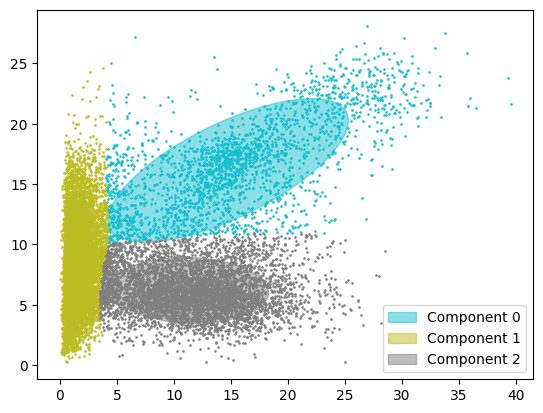

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from scipy import linalg
import numpy as np

color_iter = sns.color_palette("tab10", 10)[::-1]
Y_ = model.predict(X[features])

fig, ax = plt.subplots()

for i, (mean, cov, color) in enumerate(
    zip(
        model.means_,
        model.covariances_,
        color_iter,
    )
):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X.loc[Y_ == i, features[0]], X.loc[Y_ == i, features[1]], 0.8, color=color)

    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ellipse = Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color, label=f"Component {i}")
    ellipse.set_clip_box(fig.bbox)
    ellipse.set_alpha(0.5)
    ax.add_artist(ellipse)

plt.legend()
plt.show()

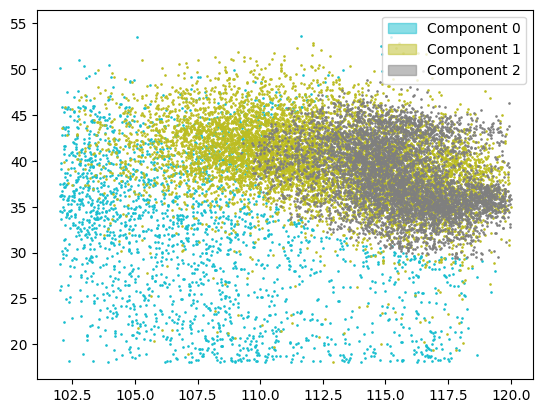

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from scipy import linalg

fig, ax = plt.subplots()

for i, (mean, cov, color) in enumerate(
    zip(
        model.means_,
        model.covariances_,
        color_iter,
    )
):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X.loc[Y_ == i, "x"], X.loc[Y_ == i, "y"], 0.8, color=color)

    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ellipse = Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color, label=f"Component {i}")
    ellipse.set_clip_box(fig.bbox)
    ellipse.set_alpha(0.5)
    ax.add_artist(ellipse)

plt.legend()
plt.show()

In [96]:
zonal_marking_id = 2 # zonal marking is component 1

In [205]:
X["p_zonal_marking"] = model.predict_proba(X[features])[:, zonal_marking_id]
X

,event_uuid,defender_id,marking_distance,location,xg,x,y,goal_distance,p_zonal_marking
0,004eb80c-da59-494f-8b24-3914b87fee1a,3,1.673564,"[113.08002939026463, 40.34870341835057]",0.0,113.080029,40.348703,6.928751,3.304975e-02
1,004eb80c-da59-494f-8b24-3914b87fee1a,5,2.137282,"[115.95197992075737, 33.999097771121725]",0.0,115.951980,33.999098,7.238598,4.345017e-02
2,004eb80c-da59-494f-8b24-3914b87fee1a,6,1.609503,"[116.93504518193657, 33.200523277025795]",0.0,116.935045,33.200523,7.458340,2.733113e-02
3,00aaa2e3-1d8c-4ad9-8ca5-7b8508073cd5,2,1.095954,"[109.85903468403481, 44.732358607644926]",0.0,109.859035,44.732359,11.190817,2.032074e-03
4,00aaa2e3-1d8c-4ad9-8ca5-7b8508073cd5,7,1.738846,"[115.70301756027081, 33.004909897991524]",0.0,115.703018,33.004910,8.209467,2.113139e-02
...,...,...,...,...,...,...,...,...,...
15387,ff912971-058c-4a3f-9381-57f9bf9beab1,0,9.004830,"[106.7447730606434, 33.646766070915056]",0.0,106.744773,33.646766,14.699137,4.328674e-04
15388,ff912971-058c-4a3f-9381-57f9bf9beab1,2,0.667474,"[111.59923592671362, 39.49339341791516]",0.0,111.599236,39.493393,8.416026,2.159712e-02
15389,ff912971-058c-4a3f-9381-57f9bf9beab1,5,17.638887,"[114.04262051499, 40.843182888512516]",0.0,114.042621,40.843183,6.016754,9.995831e-01
15390,ffb6f22a-afcd-49a3-a8e6-296e955f87fc,7,23.610474,"[115.67455096993513, 23.337212725545953]",0.0,115.674551,23.337213,17.215051,1.829782e-08


In [206]:
work_df = spark.createDataFrame(X)

In [207]:
import numpy as np
from pyspark.sql import DataFrame, Column
import pyspark.sql.functions as func
from pyspark.sql.types import ArrayType, DoubleType

box_edge_off = 102
xmax = 120
box_edge_left = 18
box_edge_right = 62

max_pitch_length = xmax - box_edge_off
max_pitch_width = box_edge_right - box_edge_left
x_bins, y_bins = max_pitch_length, max_pitch_width


bin_names = [f"{x};{y}" for y in range(y_bins) for x in range(x_bins)]


def discretize_pitch_coordinate(coordinate: Column, bins: int = 20, max_pitch_coordinate: float = 100) \
        -> Column:
    """
    Discretizes a pitch coordinate into bins for spatial analysis.

    Args:
        coordinate (Column): Column containing the pitch coordinate values.
        bins (int): Number of bins for discretization.
        max_pitch_coordinate (float): Maximum pitch coordinate value.

    Returns:
        Column: Discretized column representing the pitch coordinate in bins.
    """
    return func.when(
        coordinate != func.lit(max_pitch_coordinate),
        func.floor(coordinate * func.lit(bins / max_pitch_coordinate))
    ).otherwise(func.lit(bins - 1))


heatmap_df = (
    work_df
    .withColumn(
        "x_bin",
        discretize_pitch_coordinate(
            func.col('x') - box_edge_off, bins=x_bins, max_pitch_coordinate=max_pitch_length
        )
    )
    .withColumn(
        "y_bin",
        discretize_pitch_coordinate(
            func.col('y') - box_edge_left, bins=y_bins, max_pitch_coordinate=max_pitch_width
        )
    )
    .groupBy("event_uuid", "x_bin", "y_bin")
    .agg(func.sum("p_zonal_marking").alias("value"))
    .withColumn("loc", func.concat_ws(";", func.col("x_bin"), func.col("y_bin")))
    .groupBy("event_uuid")
    .pivot("loc", bin_names)
    .agg(func.first(func.col("value")))
    .fillna(0.0, subset=bin_names)
    .select(
        "event_uuid", func.struct(*bin_names).alias("raw_heatmap")
    )
    .toPandas()
)

In [279]:
from scipy import ndimage as ndi

def smoothing(v):
    return ndi.gaussian_filter(np.array(v).reshape(y_bins, x_bins), sigma=1.5).flatten()

heatmap_df["heatmap"] = heatmap_df["raw_heatmap"].apply(smoothing)

In [284]:
from sklearn.decomposition import NMF

n_components = 6

model = NMF(
    n_components=n_components, init='nndsvd', beta_loss='frobenius',
    solver='cd', alpha_W=1e-5, alpha_H=1e-4, l1_ratio=0.8, max_iter=3000,
    random_state=42
)
W = model.fit_transform(np.stack(heatmap_df["heatmap"].values))

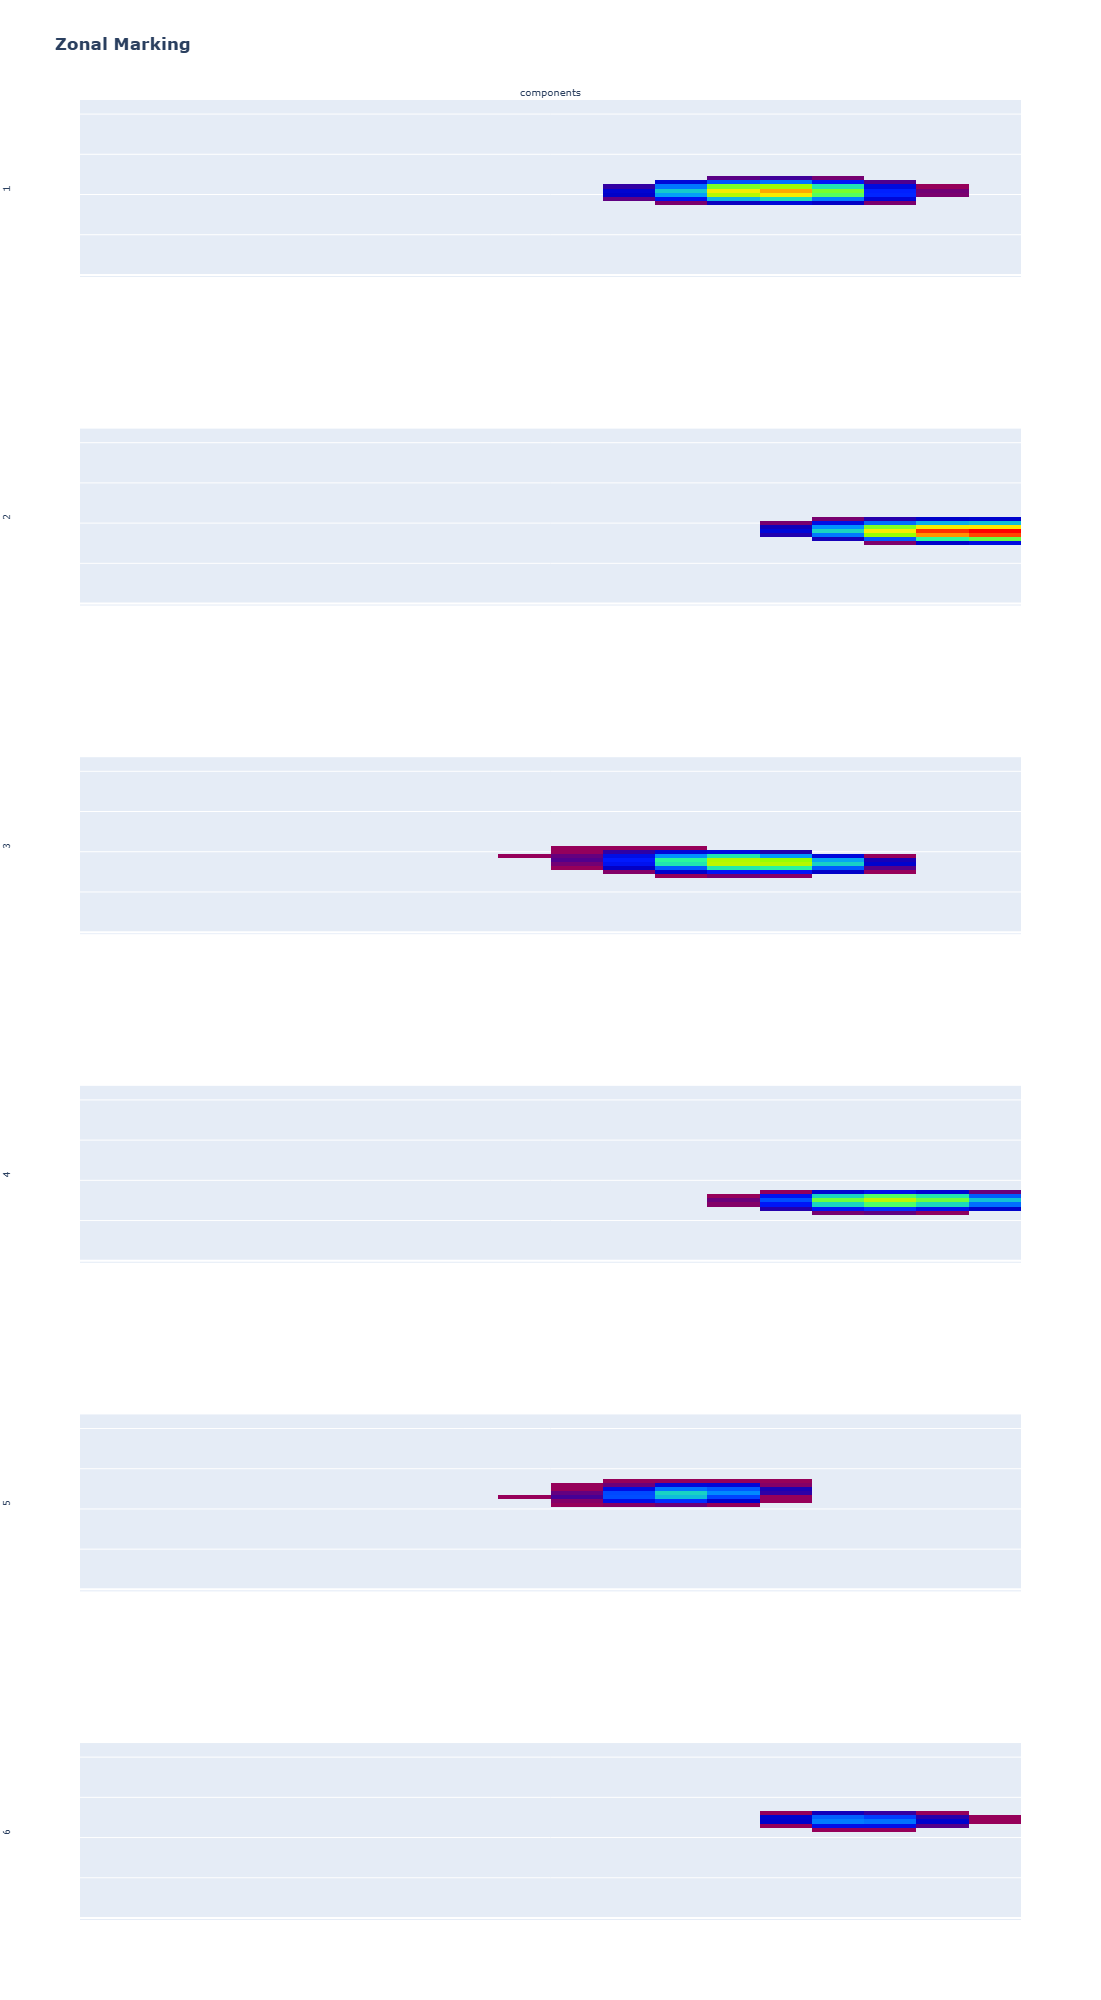

In [285]:
import plotly.subplots as sp
import plotly.graph_objs as go

h_mat = model.components_
h_mat[h_mat == 0] = 'nan'

position_subplot = sp.make_subplots(
    rows=len(h_mat), cols=1, subplot_titles=['components'], shared_xaxes=True, shared_yaxes=True
).update_layout(
    title_text=f'<b>{"Zonal Marking"}</b>',
    height=2000
)


def update_axes(heatmap_fig) -> None:
    """
    Perform standard modifications on heatmaps figure axes:
    - hide x-axis
    - revere y-axis (0 is on top in Wyscout) and hide tick labels
    - reduce annotations size

    Args:
        heatmap_fig (plotly.graph_objs.Figure): plotly heatmap figure

    Returns:
        None
    """
    heatmap_fig.update_xaxes(visible=False)
    heatmap_fig.update_yaxes(showticklabels=False)
    heatmap_fig.update_annotations(font_size=10)



for role_id, heatmaps in enumerate(h_mat):
    start_index = heatmap_id * (x_bins * y_bins)
    end_index = start_index + (x_bins * y_bins)
    heatmap = heatmaps[start_index:end_index].reshape(y_bins, x_bins)
    heatmap[heatmap < np.nanquantile(h_mat[:, start_index:end_index], 0.5)] = 'nan'
    trace = go.Heatmap(z=heatmap, colorscale='rainbow', showscale=False,
                       zmin=np.nanquantile(h_mat[:, start_index:end_index], 0.5),
                       zmax=np.nanmax(h_mat[:, start_index:end_index]))
    position_subplot.add_trace(trace, row=role_id + 1, col=1)
    
    # Set axis labels for the first column
    position_subplot.update_yaxes(
        title_text=str(role_id + 1),
        row=role_id + 1, col=1, title_font={'size': 10}
    )

update_axes(position_subplot)
position_subplot

In [293]:
W

array([[0.15501578, 0.02122172, 0.2762591 , 0.        , 0.        ,
        0.        ],
       [0.05346254, 0.06075459, 0.20168722, 0.00278085, 0.08097333,
        0.        ],
       [0.        , 0.05704966, 0.01742139, 0.13581706, 0.00187504,
        0.        ],
       ...,
       [0.09734199, 0.0711401 , 0.08669475, 0.25823322, 0.07772042,
        0.        ],
       [0.02366801, 0.        , 0.17005748, 0.        , 0.24856574,
        0.02726011],
       [0.00240858, 0.09547955, 0.02454721, 0.        , 0.        ,
        0.        ]])

In [294]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

y = (
    1 -
    pd.merge(
        heatmap_df,
        (
            work_df
            .groupBy("event_uuid")
            .agg(func.first(func.col("xg")).alias("xg"))
            .toPandas()
        ), 
        on="event_uuid", 
        how="left"
    )
    ["xg"]
)

reg = LinearRegression().fit(StandardScaler().fit_transform(W), y)

In [295]:
reg.coef_

array([-0.00060889, -0.00242295, -0.0002348 , -0.00191879, -0.00139539,
       -0.0041213 ])

In [296]:
reg.intercept_

np.float64(0.9767954362656485)

In [304]:
np.argmin(reg.predict(StandardScaler().fit_transform(W)))

np.int64(1122)

In [308]:
W.shape

(1735, 6)